In [ ]:
 #
 #                             _ooOoo_
 #                            o8888888o
 #                            88" . "88
 #                            (| -_- |)
 #                            O\  =  /O
 #                         ____/`---'\____
 #                       .'  \\|     |//  `.
 #                      /  \\|||  :  |||//  \
 #                     /  _||||| -:- |||||-  \
 #                     |   | \\\  -  /// |   |
 #                     | \_|  ''\---/''  |   |
 #                     \  .-\__  `-`  ___/-. /
 #                   ___`. .'  /--.--\  `. . __
 #                ."" '<  `.___\_<|>_/___.'  >'"".
 #               | | :  `- \`.;`\ _ /`;.`/ - ` : | |
 #               \  \ `-.   \_ __\ /__ _/   .-` /  /
 #          ======`-.____`-.___\_____/___.-`____.-'======
 #                             `=---='
 #          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
 #                     佛祖保佑        永无BUG
 #          ---------------------------------------------

In [1]:
import os
import re
import math
import time
import copy
import graphviz
import scikitplot as skplt
import pandas as pd
import numpy as np
import pydotplus
import warnings
import seaborn as sns
import xgboost as xgb
from scipy.stats import mode
import scorecardpy as sc
import plotly_express as px
import plotly.offline as py
from collections import Counter
import matplotlib.pyplot as plt
from feature_selector import FeatureSelector
from scipy import stats
from IPython.display import Image
from pyecharts import Overlap, Line, Bar, Scatter
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split,GridSearchCV,ShuffleSplit,StratifiedKFold,learning_curve,KFold,validation_curve 
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor,GradientBoostingClassifier,AdaBoostClassifier,VotingClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier
from sklearn.preprocessing import PolynomialFeatures,LabelEncoder
os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'
warnings.filterwarnings("ignore") #忽略告警信息

D:\anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.

D:\anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [2]:
def data_desc(df_table):
    t = []
    n = df_table.shape[0]
    for vals in df_table.columns.values.tolist():
        n_dtype = df_table[vals].dtype  #变量类型
        #         n=df_table[vals].count() #变量个数
        n_distinct = df_table[vals].drop_duplicates().count()  #变量去重个数
        n_miss = sum(pd.isnull(df_table[vals]))  #缺失值个数
        pct_miss = np.round(n_miss * 100 / n, 2)  #缺失比例

        if df_table[vals].dtype != 'object':
            n_min = df_table[vals].min()  #最小值
            n_max = df_table[vals].max()  #最大值
            n_mean = df_table[vals].mean()
            n_std = df_table[vals].std()
            q = stats.scoreatpercentile(df_table[vals].dropna(),
                                        [5, 25, 50, 75, 95])  #分位数
        else:
            n_min = np.nan
            n_max = np.nan
            n_mean = np.nan
            n_std = np.nan
            q = [np.nan, np.nan, np.nan, np.nan, np.nan]
        q_low = q[0] - 1.5 * (q[3] - q[1])  #75分位数-25分位数（异常值下界）
        q_upper = q[4] + 1.5 * (q[3] - q[1])  #75分位数-25分位数（异常值上界）
        t.append(
            (vals, n_dtype, n, n_distinct, n_miss, pct_miss, n_min, n_max,
             n_mean,n_std,q[0], q[1], q[2], q[3], q[4],
             (df_table[vals] < q_low).sum() + (df_table[vals] > q_upper).sum(),
             df_table.loc[(df_table[vals] > q_upper) |
                          (df_table[vals] < q_low)].index.tolist()[0:3]))
    colnums = [
        'colums', 'n_dtype', 'n_num', 'n_distinct', 'n_miss', 'pct_miss',
        'n_min', 'n_max', 'n_mean','n_std', 'q_5', 'q_25', 'q_50', 'q_75', 'q_95',
        'n_outliers', 'outliers_index'
    ]
    df_table1 = pd.DataFrame(t, columns=colnums)
    return df_table1


def var_freq(input_data, var, tag, bins):  #单变量可视化
    #input_data 输入数据集；var需要分析变量；tag目标变量;bins为分段数或手工分段list
    input_data['new_tag'] = np.where(input_data['%s' % tag] == 1, 1, 0)
    if input_data['%s' % var].dtypes != np.object and input_data[
            '%s' % var].drop_duplicates().count() > 10:  #数值型且变量类型大于10的变量执行以下代码
        if isinstance(bins, int):
            labels = [i for i in range(0, bins)]
        else:
            labels = [i for i in range(0, len(bins) - 1)]
        cut_1 = pd.cut(
            input_data['%s' % var].tolist(), bins=bins).astype(str)  #变量等宽分组十等份
        
        cut_2 = pd.cut(
            input_data['%s' % var].tolist(), bins=bins, labels=labels).astype(str)  #变量等宽分组十等份并且记录顺序
        #         cut=[j+'_'+i for i,j in zip(cut_1,cut_2)]
#         cat = pd.DataFrame({'%s_gap' % var: cut_1})
#         input_data = pd.merge(input_data, cat, left_index=False, right_index=True)  #分组变量与原表组合
        input_data['%s_gap'%var]=cut_1
        input_data['labels'] = cut_2.astype(float)  #引入labels变量主要是为了解决字符变量排序问题
        df_groupby = input_data.fillna(-999).groupby(
            ['labels', '%s_gap' % var])['PassengerId', 'new_tag'].agg({
                'PassengerId': ['count'],'new_tag':'sum'}).reset_index()
    else:
        input_data['labels'] = input_data['%s' % var]
        df_groupby = input_data.fillna(-999).groupby(
            ['labels', '%s' % var])['PassengerId', 'new_tag'].agg({'PassengerId': ['count'],'new_tag':'sum'}).reset_index()
    var_name = df_groupby.columns.values.tolist()
    df_groupby.drop(var_name[0], inplace=True, axis=1)  #排序完成，删除labels变量
    input_data.drop(['labels', 'new_tag'], axis=1, inplace=True)

    #####计算各个指标
    df_groupby['pct_all_user_sum'] = round(
        df_groupby[var_name[2]] * 100 / (df_groupby[var_name[2]].sum()), 2)
    df_groupby['pct_good_user_sum'] = round(
        df_groupby[var_name[3]] * 100 / (df_groupby[var_name[3]].sum()), 2)
    df_groupby['pct_good_user'] = round(
        df_groupby[var_name[3]] * 100 / df_groupby[var_name[2]], 2)
    df_groupby['woe'] = round(
        ((df_groupby[var_name[3]] / df_groupby[var_name[3]].sum()) / (
            (df_groupby[var_name[2]] - df_groupby[var_name[3]]) /
            (df_groupby[var_name[2]] - df_groupby[var_name[3]]).sum())
         ).apply(lambda x: math.log(x) if x > 0 else 0), 3)
    df_groupby['iv'] =((df_groupby[var_name[3]]/df_groupby[var_name[3]].sum())-((df_groupby[var_name[2]]-df_groupby[var_name[3]])/(df_groupby[var_name[2]]-df_groupby[var_name[3]]).sum()))\
                     *((df_groupby[var_name[3]]/df_groupby[var_name[3]].sum())/((df_groupby[var_name[2]]-df_groupby[var_name[3]])/(df_groupby[var_name[2]]-df_groupby[var_name[3]]).sum())).\
                        apply(lambda x: math.log(x) if x>0 else 0)
    df_groupby['iv_sum'] = df_groupby['iv'].apply(lambda x: x if x != float(
        'inf') else 0).cumsum(axis=0)

    #####绘图部分
    var_name = df_groupby.columns.values.tolist()
    bar = Bar(title='%s' % var_name[0][0])
    bar.add(
        '用户数',
        df_groupby[var_name[0]],
        df_groupby[var_name[1]],
        is_lable_show=True,
        is_datazoom_show=True,
        datazoom_range=[0, 100])
    line = Line()
    line.add(
        '存活率',
        df_groupby[var_name[0]],
        df_groupby[var_name[5]],
        is_lable_show=True,
        is_smooth=True)
    overlap = Overlap(width=1200, height=600)
    overlap.add(bar)
    overlap.add(line, is_add_yaxis=True, yaxis_index=1)
    overlap.render('./泰坦尼克/%s_分布.html' % var_name[0][0])
    return df_groupby


def var_freq_2(put_data, var1, var2, tag):  #var1与var2两个变量关于tag的散点图
    #put_data输入数据集，var1,var2为需分析的两个变量，tag为目标变量
    flag = np.unique(put_data['%s' % tag])
    colors = [plt.cm.tab10(i / float(len(flag) - 1)) for i in range(len(flag))]
    # Draw Plot for Each Category
    plt.figure(figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')

    for i, category in enumerate(flag):
        plt.scatter(
            '%s' % var1,
            '%s' % var2,
            data=put_data.loc[put_data['%s' % tag] == category, :],
            s=2,
            cmap=colors[i],
            label=str(category))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('%s' % var1)
    plt.ylabel('%s' % var2)
    plt.title("%(var1)s&&%(var2)s" % {'var1': var1, 'var2': var2}, fontsize=22)
    plt.legend(fontsize=12)
    plt.savefig('./泰坦尼克/%(var1)s&&%(var2)s.png' % {'var1': var1, 'var2': var2})
    plt.show()


def var_astype(data, var):  #将离散变量转换成数值变量(变量本身无序：如性别)
    lable = data[var].unique().tolist()
    data[var] = data[var].apply(lambda x: lable.index(x))  #将离散变量转换成数值变量


def plot_learning_curve(estimator,x,y,title,ylim=None,n_jobs=1,train_sizes=np.linspace(0.1, 1, 5),
                        cv=ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)):
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('train examples')
    plt.ylabel('score')
    train_sizes,train_score,test_score=learning_curve(estimator,x,y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes)
    train_scores_mean = np.mean(train_score, axis=1)
    train_scores_std = np.std(train_score, axis=1)
    test_scores_mean = np.mean(test_score, axis=1)
    test_scores_std = np.std(test_score, axis=1)
    plt.grid()
    
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,color='r')
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='trains_score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='test_score')
    plt.legend(loc='best')
    return plt


def plot_validation_curve(estimator,x,y,param_nm,param_range):
    train_score2,validation_score2=validation_curve(estimator,x,y,param_name=param_nm,
                                                cv=ShuffleSplit(n_splits=10, test_size=0.2, random_state=0),
                                                param_range=param_range) #改变变量C，来看得分
    train_score2_mean,train_score2_std=train_score2.mean(1),train_score2.std(1)
    validation_score2_mean,validation_score2_std=validation_score2.mean(1),validation_score2.std(1)

    fig=plt.figure(figsize=(10,8), dpi=80, facecolor='w', edgecolor='k')
    plt.grid()
    plt.fill_between(param_range,train_score2_mean-train_score2_std,
                 train_score2_mean+train_score2_std,color='r',alpha=0.1)
    plt.fill_between(param_range,validation_score2_mean-validation_score2_std,
                 validation_score2_mean+validation_score2_std,color='g',alpha=0.1)
    
    plt.plot(param_range,train_score2_mean,'o-',c='r',label='train score')
    plt.plot(param_range,validation_score2_mean,'o-',c='g',label='validation score')
    plt.legend(loc='best')
    plt.title(param_nm)
    plt.xlabel(param_nm)
    plt.ylabel('score')
    plt.show()



def polynomial_model(degree, **kwarg):  #LR增加二项式特征
    polynomial_Features = PolynomialFeatures(degree=degree, include_bias=False)
    Logistic_Regression = LogisticRegression()
    pipeline = Pipeline([('polynomial_Features', polynomial_Features),
                         ('Logistic_Regression', Logistic_Regression)])
    return pipeline

In [3]:
#数据读取查看基本特征
train_data = pd.read_csv('./file/train.csv')
test_data = pd.read_csv('./file/test.csv')
concat_data=pd.concat(objs=[train_data, test_data], axis=0).reset_index(drop=True)
pd.set_option('display.max_columns', 100)  ##设置显示列数
pd.set_option('precision', 4)  ##设置小数点位数
pd.set_option('max_colwidth', 1500)  ##设置列长度

In [4]:
###违背业务逻辑数据
concat_data.loc[concat_data['PassengerId']==280,'SibSp']=0 
concat_data.loc[concat_data['PassengerId']==1284,'SibSp']=1 
concat_data.loc[concat_data['PassengerId']==280,'Parch']=2 
concat_data.loc[concat_data['PassengerId']==1284,'Parch']=1

concat_data.loc[concat_data['PassengerId']==87,'SibSp']=3 
concat_data.loc[concat_data['PassengerId']==148,'SibSp']=3 
concat_data.loc[concat_data['PassengerId']==437,'SibSp']=3
concat_data.loc[concat_data['PassengerId']==737,'SibSp']=0
concat_data.loc[concat_data['PassengerId']==1059,'SibSp']=3
concat_data.loc[concat_data['PassengerId']==87,'Parch']=1 
concat_data.loc[concat_data['PassengerId']==148,'Parch']=1 
concat_data.loc[concat_data['PassengerId']==437,'Parch']=1 
concat_data.loc[concat_data['PassengerId']==737,'Parch']=4
concat_data.loc[concat_data['PassengerId']==1059,'Parch']=1

In [5]:
def detect_outliers(df,n,features): #筛选异常值
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices=[]
    for col in features:
        Q1=np.percentile(df[col], 25)
        Q3=np.percentile(df[col],75)
        outlier_step=1.5*(Q3 - Q1)
        outlier_list_col=df[(df[col]<Q1-outlier_step)|(df[col]>Q3+outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices=Counter(outlier_indices)        
    multiple_outliers=list(k for k,v in outlier_indices.items() if v>n)
    return multiple_outliers   

Outliers_to_drop=detect_outliers(concat_data,2,["Age","SibSp","Parch","Fare"])
concat_data=concat_data.drop(Outliers_to_drop,axis=0).reset_index(drop=True)
concat_data.shape

(1309, 12)

In [6]:
############ Cabin 变量处理
concat_data['cabin_letter']=concat_data['Cabin'].str.extract('(^[a-zA-Z])',expand=False) .fillna('X') #筛选船舱号，缺失数据用Z补齐
concat_data['cabin_has']=np.where(concat_data['Cabin'].isnull(),1,0) #判断Cabin是否缺失
concat_data['cabin_freq']=concat_data.groupby(['Cabin'])['PassengerId'].transform('count').fillna(0)
concat_data['cabin_letter_freq']=concat_data.groupby(['cabin_letter'])['PassengerId'].transform('count').fillna(0)

####依据存活率对港口进行分类
cabin_Dict={}
cabin_Dict.update(dict.fromkeys(['B','D','E'],'cabin_high'))
cabin_Dict.update(dict.fromkeys(['A','C','F','G'],'cabin_midd'))
cabin_Dict.update(dict.fromkeys(['T','X'],'cabin_low'))
concat_data['cabin_letter_bin']=concat_data['cabin_letter'].map(cabin_Dict)

In [7]:
############Parch/SibSp变量处理   
concat_data['family_size']=concat_data['Parch']+concat_data['SibSp']
concat_data['family_alone']=np.where(concat_data['family_size']>0,1,0) #判断是否孤身一人
concat_data['parch_alone']=np.where(concat_data['Parch']>0,1,0) #判断是否有Parch
concat_data['sibSp_alone']=np.where(concat_data['SibSp']>0,1,0) #判断是否有SibSp

#变量分箱
concat_data['family_size_bins']=concat_data['family_size'].apply(lambda x:x if x<2 else (2 if x<4 else 3))
concat_data['sibSp_bins']=concat_data['SibSp'].apply(lambda x:0 if x<1 else (1 if x<3 else 2))
concat_data['parch_bins']=concat_data['Parch'].apply(lambda x:0 if x<1 else (1 if x<2 else 2))
# concat_data.head()

In [8]:
########### Fare 变量处理
def fare_miss_replace(df):
    if df['Pclass']==1 and (df['Fare']==0 or pd.isnull(df['Fare'])):
        return Pclass_mean_fare_unmiss[1]
    elif df['Pclass']==2 and (df['Fare']==0 or pd.isnull(df['Fare'])):
        return Pclass_mean_fare_unmiss[2]
    elif df['Pclass']==3 and (df['Fare']==0 or pd.isnull(df['Fare'])):
        return Pclass_mean_fare_unmiss[3]
    else:
        return df['avg_fare']

##计算平均票价
concat_data['ticket_freq'] =concat_data.groupby(['Ticket'])['PassengerId'].transform('count')
concat_data['avg_fare']=concat_data['Fare']/concat_data['ticket_freq']
##对Fare=0的值用当前仓位票价均值填充
Pclass_mean_fare_unmiss=concat_data[concat_data['avg_fare']>0].groupby(['Pclass'])['avg_fare'].mean()
concat_data['avg_fare'] = concat_data.apply(fare_miss_replace,axis=1)

concat_data.loc[concat_data['Fare'].isnull(),'Fare']=concat_data.loc[concat_data['Fare'].isnull(),'avg_fare']
concat_data.loc[concat_data['Fare']==0,'Fare']=concat_data.loc[concat_data['Fare']==0,'avg_fare']

###计算票价/平均票价所包含人数
concat_data['fare_freq'] =concat_data.groupby(['Fare'])['PassengerId'].transform('count')
concat_data['avg_fare_freq'] =concat_data.groupby(['Fare'])['PassengerId'].transform('count')
#log处理
concat_data['avg_fare_log']=concat_data['avg_fare'].map(lambda i:np.log(i) if i>0 else 0) 
concat_data['fare_log']=concat_data['Fare'].map(lambda i:np.log(i) if i>0 else 0) 
#sqrt处理
concat_data['avg_fare_sqrt']=concat_data['avg_fare'].map(lambda i:np.sqrt(i) if i>0 else 0) 
concat_data['fare_sqrt']=concat_data['Fare'].map(lambda i:np.sqrt(i) if i>0 else 0) 

concat_data['ticket_freq_bins']=concat_data['ticket_freq'].apply(lambda x:0 if x<2 else (1 if x<3 else (2 if x<5 else 3)))

In [9]:
############Pclass变量处理
def pclass_fare_category(df):
    if df['Pclass']==1:
        return 1
    elif df['Pclass']==2:
        if df['avg_fare']<=Pclass_mean_fare[2]:
            return 2
        else:
            return 3
    elif df['Pclass']==3:
        if df['avg_fare']<=Pclass_mean_fare[3]:
            return 4
        else:
            return 5

Pclass_mean_fare=concat_data.groupby('Pclass')['avg_fare'].mean()
concat_data['pclass_fare_category']=concat_data.apply(pclass_fare_category,axis=1)

In [10]:
############Name变量处理
concat_data['name_title']=concat_data['Name'].str.extract('([A-Za-z]+)\.',expand=False) #取姓名称谓
concat_data['name_surname']=concat_data['Name'].apply(lambda x:re.split('[,.]',x)[0]) #取姓氏
concat_data['name_len'] = concat_data['Name'].apply(lambda x:len(''.join(x.split()))) #姓名长度
concat_data['name_surname_freq'] =concat_data.groupby(['name_surname'])['PassengerId'].transform('count')#取姓氏频率
#####将姓名称谓手动归类
title_Dict={}
title_Dict.update(dict.fromkeys(['Capt','Col','Countess','Don','Dr','Jonkheer','Major','Sir','Dona','Lady'],'Officer'))
title_Dict.update(dict.fromkeys(['Mme','Ms','Mrs'],'Mrs'))
title_Dict.update(dict.fromkeys(['Mlle','Miss'],'Mrs'))
title_Dict.update(dict.fromkeys(['Mr','Rev'],'Mr'))
title_Dict.update(dict.fromkeys(['Master'],'Master'))

concat_data['name_title'] = concat_data['name_title'].map(title_Dict)
concat_data['woman_kid']=((concat_data['name_title']=='Master')|(concat_data['Sex']=='female')
                          |(concat_data['Age']<=15)).replace({True:1,False:0})

In [11]:
############Embarked变量处理
concat_data.loc[concat_data['Embarked'].isnull(),'Embarked']=concat_data['Embarked'].value_counts(ascending=False).index[0] #众数填补

In [12]:
############Ticket变量处理
concat_data['ticket_str']=concat_data['Ticket'].str.split().str[0]
concat_data['ticket_str']=concat_data['ticket_str'].apply(lambda x:'X' if x.isdigit() 
                                                                else x.replace("/","").replace(".",""))
concat_data['ticket_int']=concat_data['Ticket'].apply(lambda x:1 if x.isdigit() else 0)

In [13]:
############Age变量处理
concat_data['age_old']=np.where(concat_data['Age']>60,1,0) #增加一个老人分类
concat_data['Age_has']=np.where(concat_data['Age'].isnull(),1,0) #判断Age是否缺失
concat_data.loc[concat_data['Age'].isnull(),'Age']=concat_data.loc[concat_data['Age'].isnull(),'Age'].fillna(-1)

In [14]:
def var_woe(a):
    a=max(a,0.12); # avoids log(0)
    a=min(a,0.9); # avoids division by 0
    return np.log(a/(1-a)/(342/549));
concat_data['sex_pclass_fare_woe']=concat_data.groupby(['Sex','pclass_fare_category'])['Survived'].transform(lambda x:var_woe(x.sum()/x.count()))

{'female': 0, 'male': 1}


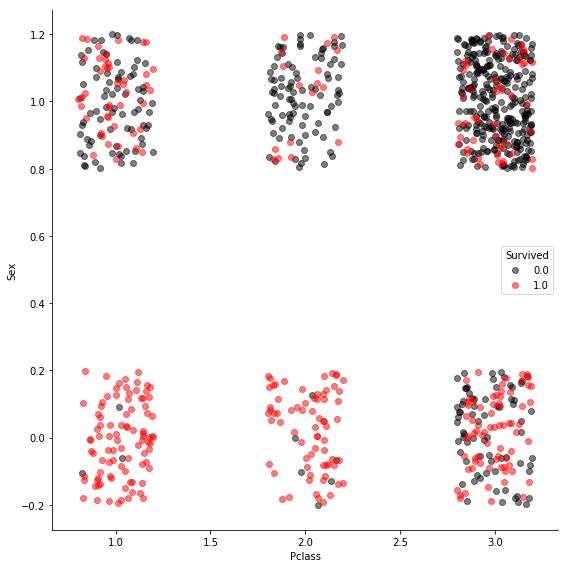

In [15]:
df2=copy.deepcopy(concat_data)
def var_astype(data,var,lable):#将离散变量转换成数值变量(变量本身无序：如性别),lable用来设定排序大小
    if lable==None:
        lable=np.sort(data[var].unique()).tolist()
    data[var]=data[var].apply(lambda x:lable.index(x)) #将离散变量转换成数值变量
    var_dict={var_nm:index for index,var_nm in enumerate(lable)}
    print(var_dict)

var_astype(df2,'Sex',None)
sns.lmplot(data=df2[df2['Survived'].notnull()],
           x='Pclass',y='Sex',hue='Survived',#col="Pclass",
           size=8,aspect=1,fit_reg = False,x_jitter=0.2,y_jitter=0.2,legend_out=False,
           palette={1:"r", 0:"black"},scatter_kws={'alpha' : 1/2})

plt.savefig('./泰坦尼克/sns_lmplot.jpg', dpi=100,bbox_inches='tight')

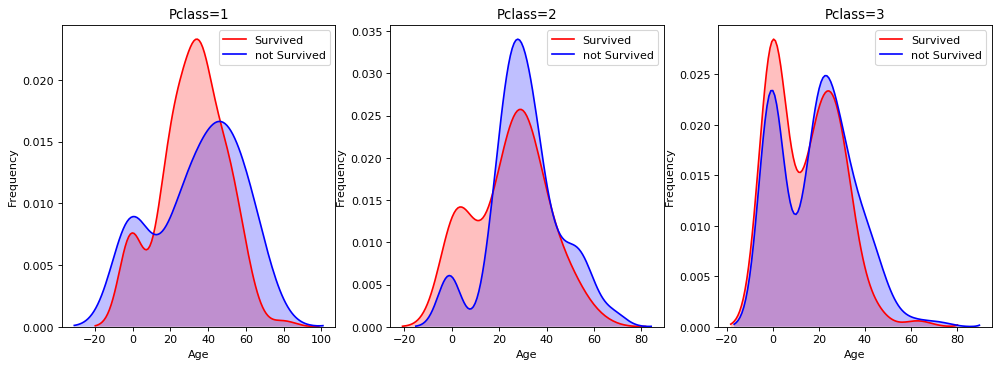

In [16]:
####Pcalss与age关系
fig = plt.figure(figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
for i in np.unique(concat_data['Pclass']):
    fig.add_subplot(1,3,i)
    g = sns.kdeplot(concat_data[(concat_data.Survived==1)&(concat_data['Pclass']==i)]['Age'], 
                color='Red', shade=True,)
    g = sns.kdeplot(concat_data[(concat_data.Survived==0)&(concat_data['Pclass']==i)]['Age'], 
                color='Blue', shade=True)
    g.legend(['Survived', 'not Survived'])
    g.set_xlabel('Age')
    g.set_ylabel('Frequency')
    plt.title('Pclass=%s'%i)

In [17]:
###Pclass与Age融合衍生
def pclass_age(df):
    if df['Pclass']==1 and df['Age']>=20 and df['Age']<=40:
        return 1
    elif df['Pclass']==2 and df['Age']>0 and df['Age']<=15:
        return 1
    elif df['Pclass']==3 and df['Age']>0 and df['Age']<=10:
        return 1
    else:
        return 0

concat_data['pclass_age']=concat_data.apply(pclass_age,axis=1)

In [18]:
#####变量分类
#定义连续变量、无序变量、有序变量、删除变量、其他变量
continuous_col_list,category_col_list,ord_col_list,drop_col_list,other_list=[],[],[],[],[]
for val in concat_data.columns.tolist():
    val_dtype=concat_data[val].dtype
    val_values=concat_data[val].drop_duplicates().count()
    pct_miss = np.round(sum(pd.isnull(concat_data[val]))*100/concat_data.shape[0],2)  #缺失比例          
    if pct_miss>20 or val_values>=concat_data.shape[0]*0.9:
        drop_col_list.append(val)     
    elif  val_dtype=='object':
        if val_values>10:
            drop_col_list.append(val)
        else:
            category_col_list.append(val)
    else:
        if val_values>10:
            continuous_col_list.append(val)
        else:
            other_list.append(val) 
        


concat_data[continuous_col_list].head()
concat_data[category_col_list].head()
concat_data[drop_col_list].head()

,Cabin,Name,PassengerId,Survived,Ticket,name_surname,ticket_str
0,NaN,"Braund, Mr. Owen Harris",1,0.0,A/5 21171,Braund,A5
1,C85,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",2,1.0,PC 17599,Cumings,PC
2,NaN,"Heikkinen, Miss. Laina",3,1.0,STON/O2. 3101282,Heikkinen,STONO2
3,C123,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",4,1.0,113803,Futrelle,X
4,NaN,"Allen, Mr. William Henry",5,0.0,373450,Allen,X


In [19]:
####有序变量LabelEncoder映射
concat_data['Embarked']=LabelEncoder().fit_transform(concat_data['Embarked'].values)
cabin_letter_bin_list={'cabin_high':0,'cabin_midd':1,'cabin_low':2}
concat_data['cabin_letter_bin']=concat_data['cabin_letter_bin'].map(cabin_letter_bin_list)

In [20]:
####无序变量onehot编码
category_col_list=[ 'Sex','cabin_letter','name_title']
concat_data=pd.get_dummies(concat_data,columns=category_col_list,dtype=int) #名义变量变量one_hot编码 

In [21]:
def optimal_binning_boundary(x:pd.Series,y:pd.Series, nan:float=-999.):  ###输出最优分段断点
    ####利用决策树获得最优分箱的边界值列表
    boundary = []  # 待return的分箱边界值列表
    x=x.fillna(nan).values  # 填充缺失值
    y=y.values
    
    KFold=StratifiedKFold(n_splits=10)
    min_impurity_decrease={'min_impurity_decrease':np.linspace(0,0.5,51),
                       'criterion':['gini','entropy'],
                       'min_samples_leaf':[0.05],
                       'max_depth':range(1,5)}
    clf_cv=GridSearchCV(DecisionTreeClassifier(),min_impurity_decrease,cv=KFold,n_jobs=25, verbose=1,)
    clf_cv.fit(x.reshape(-1, 1),y)
    clf=clf_cv.best_estimator_.fit(x.reshape(-1, 1),y)
    ####绘制决策树
    dot_tree=export_graphviz(clf,out_file=None,
                           class_names="Survived",
                           filled=True,rounded=True,special_characters=True)
    graph=pydotplus.graph_from_dot_data(dot_tree)
    img=Image(graph.create_png())
    graph.write_png("./泰坦尼克/dt_mode.png")
    
    n_nodes=clf.tree_.node_count
    children_left=clf.tree_.children_left
    children_right=clf.tree_.children_right
    threshold=clf.tree_.threshold
    for i in range(n_nodes):
        if children_left[i] != children_right[i]:  # 获得决策树节点上的划分边界值
            boundary.append(threshold[i])
    boundary.sort()
    min_x=x.min()-99
    max_x=x.max()+99  # +0.1是为了考虑后续groupby操作时，能包含特征最大值的样本
    boundary=[min_x]+boundary+[max_x]
    return boundary

def var_woe_transform(input_data, var, tag, bins):  #依据分段将数据转化成woe
    #input_data 输入数据集；var需要分析变量；tag目标变量;bins为分段数或手工分段list
    input_data['new_tag']=np.where(input_data['%s'%tag]==1,1,0)
    if isinstance(bins,int):
        labels=[i for i in range(0,bins)]
    else:
        labels=[i for i in range(0,len(bins)-1)]
    cut_1=pd.cut(input_data['%s'%var].tolist(),bins=bins).astype(str)  #变量等宽分组十等份
    cut_2=pd.cut(input_data['%s'%var].tolist(),bins=bins,labels=labels).astype(str)  #变量等宽分组十等份并且记录顺序
    input_data['%s_gap'%var]=cut_1
    input_data['labels']=cut_2.astype(float)  #引入labels变量主要是为了解决字符变量排序问题
    input_data['%s_woe'%var]=input_data.groupby(['labels'])['new_tag'].transform(lambda x:var_woe(x.sum()/x.count()))
    input_data.drop(['new_tag','labels','%s_gap'%var],inplace=True,axis=1)
    return input_data

concat_data_tmp=copy.deepcopy(concat_data)
for col in continuous_col_list:
    var_best_bins=optimal_binning_boundary(concat_data.loc[concat_data['Survived'].notnull(),col],
                         concat_data.loc[concat_data['Survived'].notnull(),'Survived'])
    print(col,len(var_best_bins),var_best_bins)
    var_freq(concat_data_tmp.loc[(concat_data_tmp['Survived'].notnull())],col,'Survived',var_best_bins)
    concat_data_tmp=var_woe_transform(concat_data_tmp,col,'Survived',var_best_bins)

concat_data_tmp.drop(continuous_col_list,inplace=True,axis=1) #删除连续变量
concat_data_tmp.head()

Fitting 10 folds for each of 408 candidates, totalling 4080 fits


[Parallel(n_jobs=25)]: Done 165 tasks      | elapsed:    9.7s
[Parallel(n_jobs=25)]: Done 2385 tasks      | elapsed:   11.9s
[Parallel(n_jobs=25)]: Done 4080 out of 4080 | elapsed:   13.0s finished


Age 4 [-100.0, -0.2900000214576721, 6.5, 179.0]
Fitting 10 folds for each of 408 candidates, totalling 4080 fits


[Parallel(n_jobs=25)]: Done 164 tasks      | elapsed:    9.3s
[Parallel(n_jobs=25)]: Done 1948 tasks      | elapsed:   11.1s
[Parallel(n_jobs=25)]: Done 4080 out of 4080 | elapsed:   12.7s finished


Fare 9 [-94.9875, 7.731249809265137, 7.883349895477295, 8.039600372314453, 10.481249809265137, 50.98749923706055, 74.375, 107.66250610351562, 611.3292]
Fitting 10 folds for each of 408 candidates, totalling 4080 fits


[Parallel(n_jobs=25)]: Done 165 tasks      | elapsed:    9.4s
[Parallel(n_jobs=25)]: Done 2385 tasks      | elapsed:   11.6s
[Parallel(n_jobs=25)]: Done 4080 out of 4080 | elapsed:   12.7s finished


avg_fare 5 [-95.2889, 8.664583206176758, 22.287500381469727, 30.543750762939453, 227.0823]
Fitting 10 folds for each of 408 candidates, totalling 4080 fits


[Parallel(n_jobs=25)]: Done 165 tasks      | elapsed:    9.0s
[Parallel(n_jobs=25)]: Done 1955 tasks      | elapsed:   10.8s
[Parallel(n_jobs=25)]: Done 4080 out of 4080 | elapsed:   12.3s finished


fare_freq 8 [-98, 1.5, 2.5, 4.5, 6.5, 8.5, 49.5, 159]
Fitting 10 folds for each of 408 candidates, totalling 4080 fits


[Parallel(n_jobs=25)]: Done 165 tasks      | elapsed:   10.0s
[Parallel(n_jobs=25)]: Done 2385 tasks      | elapsed:   12.1s
[Parallel(n_jobs=25)]: Done 4080 out of 4080 | elapsed:   13.4s finished


avg_fare_freq 8 [-98, 1.5, 2.5, 4.5, 6.5, 8.5, 49.5, 159]
Fitting 10 folds for each of 408 candidates, totalling 4080 fits


[Parallel(n_jobs=25)]: Done 164 tasks      | elapsed:   10.1s
[Parallel(n_jobs=25)]: Done 1948 tasks      | elapsed:   12.1s
[Parallel(n_jobs=25)]: Done 4080 out of 4080 | elapsed:   13.7s finished


avg_fare_log 5 [-97.68867167137002, 2.159243583679199, 3.1028342247009277, 3.419158935546875, 103.85267302605376]
Fitting 10 folds for each of 408 candidates, totalling 4080 fits


[Parallel(n_jobs=25)]: Done 165 tasks      | elapsed:    9.2s
[Parallel(n_jobs=25)]: Done 2385 tasks      | elapsed:   11.4s
[Parallel(n_jobs=25)]: Done 4080 out of 4080 | elapsed:   12.5s finished


fare_log 9 [-97.61058551154386, 2.0452704429626465, 2.0647528171539307, 2.084378480911255, 2.3495864868164062, 3.9315340518951416, 4.309050559997559, 4.6789350509643555, 105.23896738717366]
Fitting 10 folds for each of 408 candidates, totalling 4080 fits


[Parallel(n_jobs=25)]: Done 165 tasks      | elapsed:    9.3s
[Parallel(n_jobs=25)]: Done 1955 tasks      | elapsed:   11.1s
[Parallel(n_jobs=25)]: Done 4080 out of 4080 | elapsed:   12.6s finished


avg_fare_sqrt 5 [-97.07357844696442, 2.94356632232666, 4.719557762145996, 5.526638507843018, 110.31734509503002]
Fitting 10 folds for each of 408 candidates, totalling 4080 fits


[Parallel(n_jobs=25)]: Done 165 tasks      | elapsed:   10.5s
[Parallel(n_jobs=25)]: Done 2385 tasks      | elapsed:   13.0s
[Parallel(n_jobs=25)]: Done 4080 out of 4080 | elapsed:   14.2s finished


fare_sqrt 9 [-96.99687743759898, 2.780512571334839, 2.807730197906494, 2.835418224334717, 3.2374744415283203, 7.140470027923584, 8.623945236206055, 10.375883102416992, 121.63469019006004]
Fitting 10 folds for each of 408 candidates, totalling 4080 fits


[Parallel(n_jobs=25)]: Done 165 tasks      | elapsed:    9.5s
[Parallel(n_jobs=25)]: Done 1955 tasks      | elapsed:   11.4s
[Parallel(n_jobs=25)]: Done 4080 out of 4080 | elapsed:   13.3s finished


name_len 8 [-89, 17.5, 23.5, 25.5, 28.5, 31.5, 37.5, 168]


,Cabin,Embarked,Name,Parch,PassengerId,Pclass,SibSp,Survived,Ticket,cabin_has,cabin_freq,cabin_letter_freq,cabin_letter_bin,family_size,family_alone,parch_alone,sibSp_alone,family_size_bins,sibSp_bins,parch_bins,ticket_freq,ticket_freq_bins,pclass_fare_category,name_surname,name_surname_freq,woman_kid,ticket_str,ticket_int,age_old,Age_has,sex_pclass_fare_woe,pclass_age,Sex_female,Sex_male,cabin_letter_A,cabin_letter_B,cabin_letter_C,cabin_letter_D,cabin_letter_E,cabin_letter_F,cabin_letter_G,cabin_letter_T,cabin_letter_X,name_title_Master,name_title_Mr,name_title_Mrs,name_title_Officer,Age_woe,Fare_woe,avg_fare_woe,fare_freq_woe,avg_fare_freq_woe,avg_fare_log_woe,fare_log_woe,avg_fare_sqrt_woe,fare_sqrt_woe,name_len_woe
0,NaN,2,"Braund, Mr. Owen Harris",0,1,3,1,0.0,A/5 21171,1,0.0,1014,2,1,1,0,1,1,1,0,1,0,4,Braund,2,0,A5,0,0,0,-1.0452,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,-0.5666,-1.5191,-1.0606,-1.1790,-1.1790,-1.0606,-1.5191,-1.0606,-1.5191,-0.8746
1,C85,0,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",0,2,1,1,1.0,PC 17599,0,2.0,94,1,1,1,0,1,1,1,0,2,1,1,Cumings,2,1,PC,0,0,0,2.6705,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,-0.5666,-0.0318,0.0277,-0.1103,-0.1103,0.0277,-0.0318,0.0277,-0.0318,0.4893
2,NaN,2,"Heikkinen, Miss. Laina",0,3,3,0,1.0,STON/O2. 3101282,1,0.0,1014,2,0,0,0,0,0,0,0,1,0,5,Heikkinen,1,1,STONO2,0,0,0,0.7610,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,-0.5666,-1.3985,-1.0606,-1.1790,-1.1790,-1.0606,-1.3985,-1.0606,-1.3985,-0.8746
3,C123,2,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1.0,113803,0,2.0,94,1,1,1,0,1,1,1,0,2,1,1,Futrelle,2,1,X,1,0,0,2.6705,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,-0.5666,-0.0318,0.2845,-0.4697,-0.4697,0.2845,-0.0318,0.2845,-0.0318,0.4893
4,NaN,2,"Allen, Mr. William Henry",0,5,3,0,0.0,373450,1,0.0,1014,2,0,0,0,0,0,0,0,1,0,5,Allen,2,0,X,1,0,0,-1.5191,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,-0.5666,-1.5191,-1.0606,-0.8260,-0.8260,-1.0606,-1.5191,-1.0606,-1.5191,-0.8746


In [22]:
drop_col_list.remove('Survived')
concat_data_tmp.drop(drop_col_list,inplace=True,axis=1) #删除部分变量

In [23]:
x_train=concat_data_tmp[pd.notnull(concat_data_tmp['Survived'])].drop('Survived',axis=1) #删除部分变量
y_train=concat_data_tmp[pd.notnull(concat_data_tmp['Survived'])].Survived

x_test=concat_data_tmp[pd.isnull(concat_data_tmp['Survived'])].drop('Survived',axis=1) #删除部分变量

In [24]:
fs=FeatureSelector(data = x_train,labels =y_train)
fs.identify_all(selection_params = {
 'missing_threshold': 0.6, ##缺失比例
 'correlation_threshold': 0.9,  #相关系数
 'task': 'classification', ##目标类型(回归还是分类)
 'eval_metric': 'auc', ##缺失比例
 'cumulative_importance': 0.95 ##累计贡献比例
                                   })
x_train=fs.remove(methods ='all',)
# x_train.head(10)

0 features with greater than 0.60 missing values.

0 features with a single unique value.

18 features with a correlation magnitude greater than 0.90.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[84]	valid_0's auc: 0.888889
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[23]	valid_0's auc: 0.868824
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[3]	valid_0's auc: 0.834334
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[56]	valid_0's auc: 0.927978
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[83]	valid_0's auc: 0.876524
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[194]	valid_0's auc: 0.871411
Training until validation scores don't improve for 1

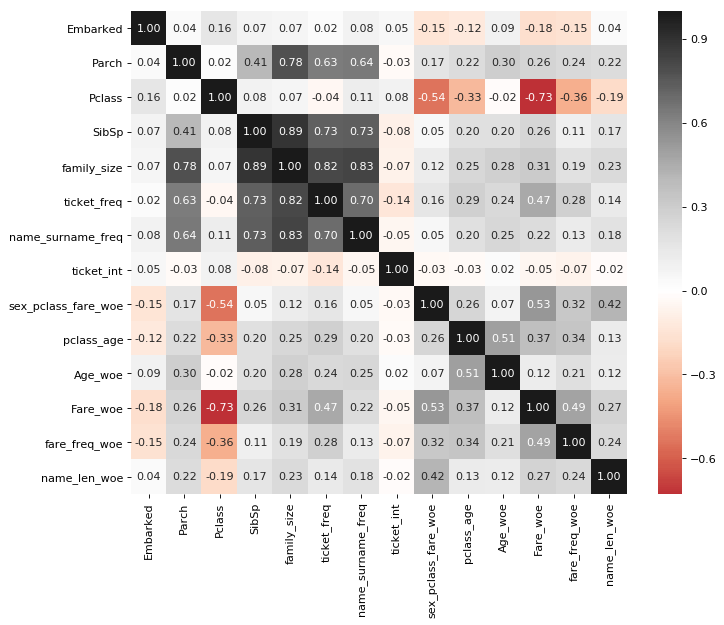

In [25]:
plt.figure(figsize=(10, 8), dpi=80, edgecolor='k').add_subplot(1,1,1)
sns.heatmap(x_train.corr(),annot=True,cbar=True,cmap='RdGy',fmt = ".2f",center=0)
plt.savefig('./泰坦尼克/sns_heatmap.jpg', dpi=100,bbox_inches='tight')

In [26]:
###### 决策树算法
#决策树算法调参
start_dt=time.time()
KFold=StratifiedKFold(n_splits=10)
min_impurity_decrease={'min_impurity_decrease':np.linspace(0,0.5,51),
                       'criterion':['gini','entropy'],
                       'min_samples_leaf':[t for t in range(20,101,10)],
                       'max_depth':range(1,5)}
dt_model_cv=GridSearchCV(DecisionTreeClassifier(),min_impurity_decrease,cv=KFold,n_jobs=25, verbose=1,)
dt_model_cv.fit(x_train,y_train)
end_dt=time.time()
print('best_params:%s\nbest_score:%.4f\n耗时：%.1f'%(dt_model_cv.best_params_,dt_model_cv.best_score_,end_dt-start_dt))
# print(dt_model.cv_results_) #执行详细过程

Fitting 10 folds for each of 3672 candidates, totalling 36720 fits


[Parallel(n_jobs=25)]: Done 154 tasks      | elapsed:   31.4s
[Parallel(n_jobs=25)]: Done 1062 tasks      | elapsed:   33.3s
[Parallel(n_jobs=25)]: Done 2462 tasks      | elapsed:   36.0s
[Parallel(n_jobs=25)]: Done 4262 tasks      | elapsed:   39.4s
[Parallel(n_jobs=25)]: Done 6462 tasks      | elapsed:   44.6s
[Parallel(n_jobs=25)]: Done 9062 tasks      | elapsed:   50.4s
[Parallel(n_jobs=25)]: Done 12062 tasks      | elapsed:   56.4s
[Parallel(n_jobs=25)]: Done 15462 tasks      | elapsed:  1.1min
[Parallel(n_jobs=25)]: Done 19262 tasks      | elapsed:  1.2min
[Parallel(n_jobs=25)]: Done 23462 tasks      | elapsed:  1.3min
[Parallel(n_jobs=25)]: Done 28062 tasks      | elapsed:  1.5min
[Parallel(n_jobs=25)]: Done 33062 tasks      | elapsed:  1.7min
[Parallel(n_jobs=25)]: Done 36720 out of 36720 | elapsed:  1.8min finished


best_params:{'criterion': 'gini', 'max_depth': 4, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 30}
best_score:0.8249
耗时：119.0


In [57]:
#随机森林算法调参
KFold=StratifiedKFold(n_splits=10)
start_dt=time.time()
min_impurity_decrease={'n_estimators':np.linspace(1,100,51).astype('int'),
                       'min_impurity_decrease':np.linspace(0,0.5,51),
                       'min_samples_leaf':[t for t in range(20,101,10)],
                       'max_depth':range(1,5)}
rf_model_cv=GridSearchCV(RandomForestClassifier(),min_impurity_decrease,cv=KFold,n_jobs=-1, verbose=1)
rf_model_cv.fit(x_train_del,y_train)

end_dt=time.time()
print('best_params:%s\nbest_score:%.4f\n耗时：%.1f'%(rf_model_cv.best_params_,rf_model_cv.best_score_,end_dt-start_dt))

Fitting 10 folds for each of 93636 candidates, totalling 936360 fits


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 525 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 1185 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1885 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2752 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 3593 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 5431 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 7559 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 9603 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 12055 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 14311 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 17189 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 19843 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done 22703 tasks      | elapsed: 21.3min
[Parallel(n_jobs=-1)]: Done 25829 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 29421 tasks      | elap

best_params:{'max_depth': 3, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 20, 'n_estimators': 6}
best_score:0.8316
耗时：52685.4


In [379]:
#########GBDT算法调参
start_dt=time.time()
min_impurity_decrease={'n_estimators':np.linspace(2,200,100).astype('int'),
                       'learning_rate':np.linspace(0.01,0.5,50),
                       'subsample':np.linspace(0.5,0.8,11),
                       'max_depth':range(1,5)}
gbdt_model_cv=GridSearchCV(GradientBoostingClassifier(),min_impurity_decrease,cv=5,n_jobs=-1, verbose=1)
gbdt_model_cv.fit(x_train_del,y_train)
end_dt=time.time()
print('best_params:%s\nbest_score:%.4f\n耗时：%.1f'%(gbdt_model_cv.best_params_,gbdt_model_cv.best_score_,end_dt-start_dt))


Fitting 5 folds for each of 220000 candidates, totalling 1100000 fits


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 1509 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 2259 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 3309 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4659 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 6298 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 8912 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 10412 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 13888 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 15288 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 16338 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 19345 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 20595 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 21945 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 28989 tasks      | elapsed: 24.9min
[Parallel(n_jobs=-1)]: Done 32797 tasks      | e

{'learning_rate': 0.09, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.68}

In [27]:
#########xgboost算法调参
KFold=StratifiedKFold(n_splits=5)
start_dt=time.time()
cv_params = {'n_estimators':[int(i) for i in np.linspace(20,200,21)],
            'max_depth': [3, 4, 5], 
             'learning_rate': [0.01,0.03,0.1],
             'reg_alpha':[1e-5, 1e-2, 0.1, 0.5,1],
             'gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
             'subsample': [0.8],
             'colsample_bytree': [0.8],
             'objective':['binary:logistic'],
             'min_child_weight': [1, 2, 3, 4, 5, 6]}
end_dt=time.time()
xgb_model_cv = GridSearchCV(estimator=xgb.XGBClassifier(),param_grid=cv_params, scoring='accuracy', cv=KFold, verbose=1, n_jobs=-1)
xgb_model_cv.fit(x_train, y_train)
print('best_params:%s\nbest_score:%.4f\n耗时：%.1f'%(xgb_model_cv.best_params_,xgb_model_cv.best_score_,end_dt-start_dt))

Fitting 5 folds for each of 34020 candidates, totalling 170100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 838 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 1538 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2438 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3538 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 4579 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 5371 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 7013 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 8343 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 10328 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 12628 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 15128 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 17808 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 20082 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 22835 tasks      | elapse

best_params:{'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 137, 'objective': 'binary:logistic', 'reg_alpha': 1e-05, 'subsample': 0.8}
best_score:0.8507
耗时：0.0


In [631]:
#########Adaboost算法调参
start_dt=time.time()
min_impurity_decrease={'n_estimators':np.linspace(2,200,100).astype('int'),
                       'learning_rate':np.linspace(0.01,1,100)}
ada_model_cv=GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(max_depth=3, min_samples_split=100, min_samples_leaf=50)),min_impurity_decrease,cv=5,n_jobs=-1, verbose=1)
ada_model_cv.fit(x_train,y_train)
end_dt=time.time()
print('best_params:%s\nbest_score:%.4f\n耗时：%.1f'%(ada_model_cv.best_params_,ada_model_cv.best_score_,end_dt-start_dt))

Fitting 5 folds for each of 10000 candidates, totalling 50000 fits


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 286 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 541 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1004 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1595 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 2336 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 3175 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 4152 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 5155 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 6353 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 7644 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 9027 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 10608 tasks      | elapsed: 23.8min
[Parallel(n_jobs=-1)]: Done 12196 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done 13970 tasks      | elapsed: 31.5min
[Parallel(n_jobs=-1)]: Done 15745 tasks      | elapsed:

{'learning_rate': 0.6, 'n_estimators': 10}

In [28]:
#########KNN算法调参
start_dt=time.time()
min_impurity_decrease={'n_neighbors':np.linspace(1,100,100).astype('int'),
                      'weights':['uniform','distance'],
                      'algorithm':['brute','kd_tree','ball_tree','auto']}
knn_model_cv=GridSearchCV(KNeighborsClassifier(),min_impurity_decrease,cv=10,n_jobs=-1, verbose=1)
knn_model_cv.fit(x_train,y_train)
end_dt=time.time()
print('best_params:%s\nbest_score:%.4f\n耗时：%.1f'%(knn_model_cv.best_params_,knn_model_cv.best_score_,end_dt-start_dt))

Fitting 10 folds for each of 800 candidates, totalling 8000 fits


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 945 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 2445 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 4545 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 7245 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 8000 out of 8000 | elapsed:  2.4min finished


best_params:{'algorithm': 'brute', 'n_neighbors': 7, 'weights': 'uniform'}
best_score:0.8260
耗时：144.0


In [32]:
#####################算法
#决策树算法
# dt_model=DecisionTreeClassifier(max_depth=3,min_samples_leaf=30,
#                                 min_impurity_decrease=0.01,criterion='entropy').fit(x_train,y_train)
dt_model=dt_model_cv.best_estimator_.fit(x_train,y_train)

# 随机森林算法
rf_model=RandomForestClassifier(n_estimators=90,oob_score=True,criterion='gini',min_samples_leaf=20,
                               max_features=0.6,max_depth=4).fit(x_train,y_train)
# rf_model=rf_model_cv.best_estimator_.fit(x_train,y_train)

#GBDT算法
gbdt_model = GradientBoostingClassifier(n_estimators=40,learning_rate=0.03,max_depth=2,subsample=0.56).fit(x_train,y_train)
# gbdt_model=gbdt_model_cv.best_estimator_.fit(x_train,y_train)

#xgboost算法
# xgb_model=xgb.XGBClassifier(n_estimators=40,learning_rate=0.1,max_depth=4,subsample=0.8).fit(x_train,y_train)
xgb_model=xgb_model_cv.best_estimator_.fit(x_train,y_train)

#Adaboost算法
ada_model=AdaBoostClassifier(DecisionTreeClassifier(max_depth=3, min_samples_split=100, min_samples_leaf=50),
                         algorithm="SAMME",n_estimators=25, learning_rate=0.6).fit(x_train,y_train)
# adb_model=adab_model_cv.best_estimator_.fit(x_train,y_train)

#KNN算法
knn_model=KNeighborsClassifier(algorithm='kd_tree',n_neighbors=30,weights= 'uniform').fit(x_train,y_train)
# knn_model=knn_model_cv.best_estimator_.fit(x_train,y_train)

In [33]:
#####训练集准确率、AUC、10折准确率
model_list=[dt_model,rf_model,gbdt_model,xgb_model,ada_model,knn_model]
model_list_str=['dt_model','rf_model','gbdt_model','xgb_model','ada_model','knn_model']

train_score,auc_score,cv_train_score,accuracy_scores=[],[],[],[]
for model in model_list:
    train_score.append(model.score(x_train,y_train)) #训练集准确率
    auc_score.append(roc_auc_score(y_train,model.predict_proba(x_train)[:,1])) #训练集AUC
    cv_train_score.append(cross_val_score(model,x_train,y_train,cv=10,scoring='accuracy').mean()) #训练集10折交叉验证准确性
    accuracy_scores.append(accuracy_score(y_train, model.predict(x_train)))
pd.DataFrame({"auc_score": auc_score,"train_score":train_score,
#               'accuracy_scores':accuracy_scores,
              "cv_train_score":cv_train_score,
              "ratio_cv_train_score":(np.array(train_score)-np.array(cv_train_score))*100/np.array(train_score),
              "model":model_list_str})

,auc_score,train_score,cv_train_score,ratio_cv_train_score,model
0,0.8776,0.8361,0.8251,1.3260,dt_model
1,0.8896,0.8395,0.8125,3.2120,rf_model
2,0.8773,0.8182,0.8081,1.2311,gbdt_model
3,0.9406,0.8822,0.8294,5.9764,xgb_model
4,0.9035,0.8440,0.8249,2.2624,ada_model
5,0.8869,0.8002,0.7969,0.4202,knn_model


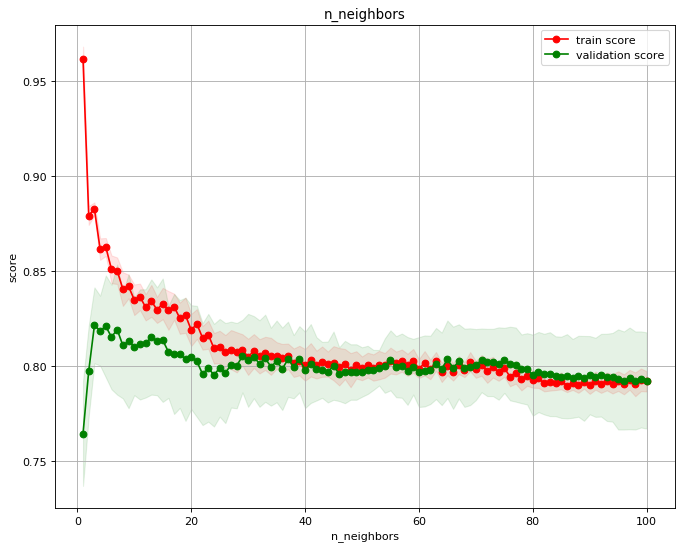

In [34]:
##knn算法参数验证曲线
plot_validation_curve(knn_model,x_train,y_train,'n_neighbors',np.linspace(1,100,100).astype('int')) 

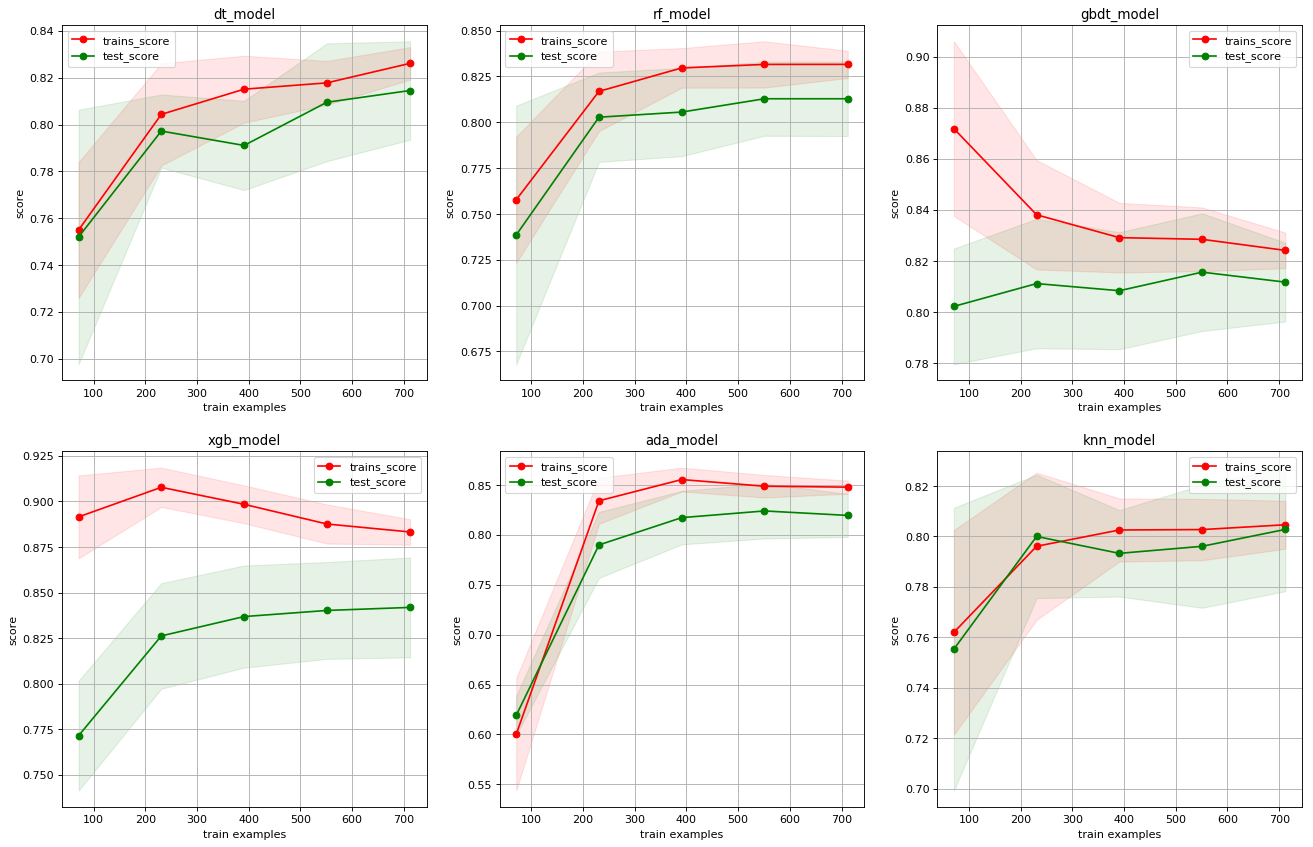

In [35]:
#####学习曲线
fig = plt.figure(figsize=(20,20), dpi=80, facecolor='w', edgecolor='k')
for model,model_str,i in zip(model_list,model_list_str,range(len(model_list))):
    fig.add_subplot(3,3,i+1)
    plot_learning_curve(model,x_train,y_train,title=model_str)
plt.savefig('./泰坦尼克/学习曲线.jpg', dpi=100,bbox_inches='tight')

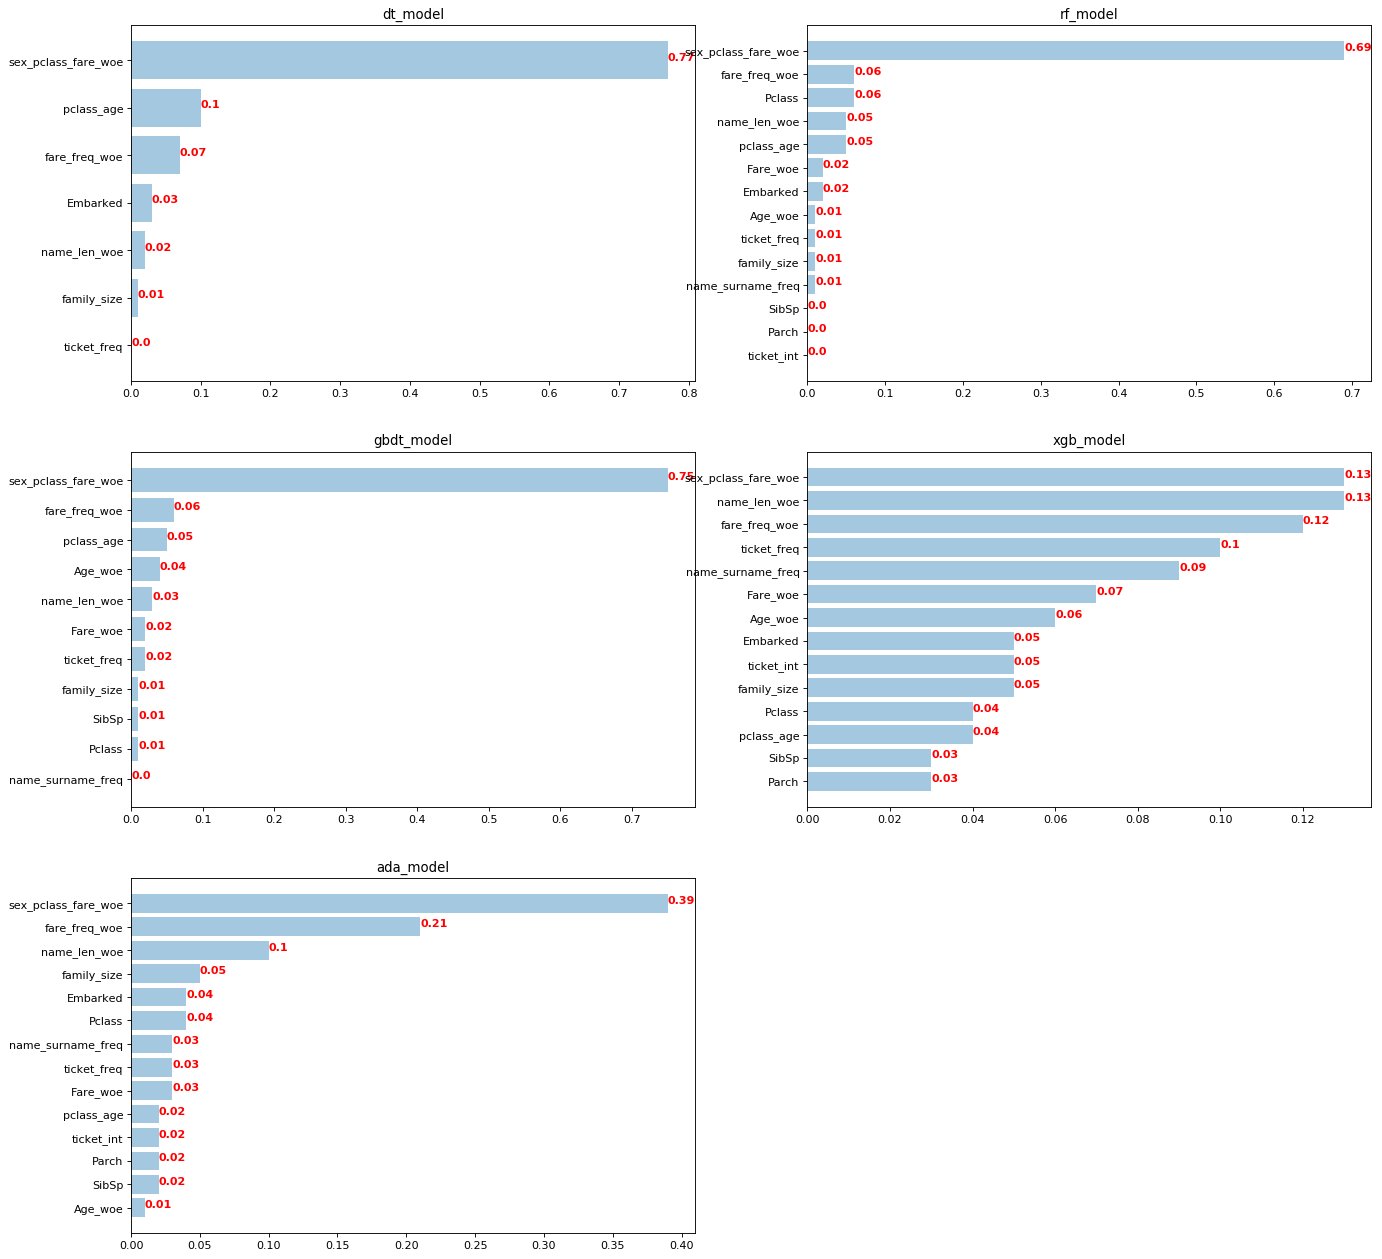

In [36]:
def model_var_importances_plot(model,title):
    importances=model.feature_importances_   #变量重要性排序
    indexs=np.argsort(importances)[::-1]
    df_col=x_train.columns
    x=[df_col[indexs[f]] for f in range(x_train.shape[1]) if importances[indexs[f]]>0 ]
    y=[round(importances[indexs[f]],2) for f in range(x_train.shape[1]) if importances[indexs[f]]>0]
#     plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    c=sorted(range(len(x)),reverse=True)
    plt.barh(c,y,align='center', alpha=0.4)
    for x1,y1 in zip(c,y): #给图标识数值
        plt.text(y1,x1,str(y1), color='red', fontweight='bold',)
    plt.yticks(c,x)
    plt.title('%s'%title)

model_list=[dt_model,rf_model,gbdt_model,xgb_model,ada_model]
model_list_str=['dt_model','rf_model','gbdt_model','xgb_model','ada_model']
#####变量重要性
fig = plt.figure(figsize=(20,20), dpi=80, facecolor='w', edgecolor='k')
for model,model_str,i in zip(model_list,model_list_str,range(len(model_list))):
    fig.add_subplot(3,2,i+1)
    model_var_importances_plot(model,model_str)
plt.savefig('./泰坦尼克/变量贡献度.jpg', dpi=100,bbox_inches='tight')

In [38]:
from sklearn.model_selection import KFold

def get_stacking(clf, x_train, y_train, x_test, n_folds=10):
    """
    这个函数是stacking的核心，使用交叉验证的方法得到次级训练集
    x_train, y_train, x_test 的值应该为numpy里面的数组类型 numpy.ndarray .
    如果输入为pandas的DataFrame类型则会把报错"""
    train_num, test_num = x_train.shape[0], x_test.shape[0]
    second_level_train_set = np.zeros((train_num,)) #用于存储clf预测x_train的结果
    second_level_test_set = np.zeros((test_num,)) #用于存储clf预测x_test的概率（10折求均值）
    test_nfolds_sets = np.zeros((test_num, n_folds)) #存储lf预测x_test的10折结果
    kf = KFold(n_splits=n_folds)
    x_train,y_train,x_test=x_train.values,y_train.values,x_test.values #将datafrema处理成array格式
    for i,(train_index, test_index) in enumerate(kf.split(x_train)):
        x_tra, y_tra = x_train[train_index], y_train[train_index]
        x_tst, y_tst = x_train[test_index], y_train[test_index]
        clf.fit(x_tra, y_tra)
        ###子模型输出分类概率
#         second_level_train_set[test_index] = clf.predict_proba(x_tst)[:,1] #累计存x_train[test_index]的计算结果
#         test_nfolds_sets[:,i] = clf.predict_proba(x_test)[:,1] #存储每次10折循环的x_test结果
        ###子模型输出分类
        second_level_train_set[test_index] = clf.predict(x_tst) #累计存x_train[test_index]的计算结果
        test_nfolds_sets[:,i] = clf.predict(x_test) #存储每次10折循环的x_test结果
    second_level_test_set[:] = test_nfolds_sets.mean(axis=1)
    return second_level_train_set, second_level_test_set

model_list=[dt_model,rf_model,gbdt_model,adb_model,knn_model]
model_list_str=['dt_model','rf_model','gbdt_model','ad_model','knn_model']

train_sets=[get_stacking(model,x_train,y_train,x_test[x_train.columns.tolist()])[0] for model in model_list]
test_sets=[get_stacking(model,x_train,y_train,x_test[x_train.columns.tolist()])[1] for model in model_list]

meta_train= np.concatenate([result_set.reshape(-1,1) for result_set in train_sets], axis=1)
meta_test = np.concatenate([y_test_set.reshape(-1,1) for y_test_set in test_sets], axis=1)

#使用逻辑回归作为我们的次级分类器
model_fin = LogisticRegression(C=1.0,penalty='l1',tol=1e-6).fit(meta_train, y_train)
df_predict = model_fin.predict(meta_test)

print('训练集准确率:{train_score:.4f};'.format(train_score=model_fin.score(meta_train, y_train))) #训练集跟测试
print('AUC:%.4f'%(metrics.roc_auc_score(y_train,model_fin.predict_proba(meta_train)[:,1]))) #计算ROC值

print('-'*20+'变量系数'+'-'*20)
for i in range(meta_train.shape[1]): #变量系数
    print(model_list_str[i],':',model_fin.coef_.tolist()[0][i])

fig = plt.figure(figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')
plot_learning_curve(model_fin,meta_train,y_train,title='model_fin') #学习曲线
pd.value_counts(np.equal(model_fin.predict(meta_train),y_train))

NameError: name 'adb_model' is not defined

In [109]:
today_dt=time.strftime("%Y%m%d%H", time.localtime()) 
submission = pd.DataFrame({ 'PassengerId':test_data['PassengerId'],
                            'Survived':  model_fin.predict(meta_test).astype(int) })
submission.to_csv("./泰坦尼克/submission_%s.csv"%today_dt, index=False,encoding='utf8')

In [636]:
####投票法
def skln_vot(vot_list,x_train,y_train,x_test, n_folds=10):
    kf = KFold(n_splits=n_folds)
    train_num, test_num = x_train.shape[0], x_test.shape[0]
    test_nfolds_sets=np.zeros((test_num,n_folds))
    clf=VotingClassifier(estimators=vot_list, voting='hard')
    x_train,y_train,x_test=x_train.values,y_train.values,x_test.values #将datafrema处理成array格式
    for i,(train_index, test_index) in enumerate(kf.split(x_train)):
        x_tra, y_tra = x_train[train_index], y_train[train_index]
        x_tst, y_tst = x_train[test_index], y_train[test_index]
        clf.fit(x_tra, y_tra)
        test_nfolds_sets[:,i] = clf.predict(x_test) #存储每次10折循环的x_test结果
    test_pre_result=pd.Series(pd.value_counts(test_nfolds_sets[i],ascending=False).index[0] for i in range(test_num))
    return test_pre_result

vot_list=[(i,j) for i,j in zip(model_list_str,model_list)]
test_pre_result=skln_vot(vot_list,x_train,y_train,x_test[x_train.columns.tolist()])

today_dt=time.strftime("%Y%m%d%H", time.localtime()) 
submission = pd.DataFrame({ 'PassengerId':test_data['PassengerId'],
                            'Survived':  test_pre_result.astype(int) })
submission.to_csv("./泰坦尼克/submission_%s.csv"%today_dt, index=False,encoding='utf8')